In [1]:
import numpy as np
from time import perf_counter
from functools import lru_cache
from scipy.integrate import solve_ivp
import scipy.optimize as optimize

from mayavi import mlab
mlab.init_notebook(backend='png')
import mlabtools

from CR3BP.CR3BP import dS_CR3BP, dSTM_CR3BP
import constants as C

Notebook initialized with png backend.


In [2]:
# initial orbit state [x, y, z, vx, vy, vz]
S_init = np.array([-0.023, -0.015, 0, 5.878, -4.409, 0])

# target position [x, y, z]
r_target = np.array([1.1, 0.036, 0.02])

# initial guess
X_0 = np.array([8, -6, 1, 0.2])

In [3]:
# The variable X of the objective function constists of
# X = [v_x, v_y, v_z, time of flight]

@lru_cache(maxsize=2, typed=True)
def solve_initial(X):
    """Solve the IVP given the objective function tuple X."""
    S_0 = np.zeros(6 + 6*3)
    S_0[:3] = S_init[:3]
    S_0[3:6] = X[:3]
    S_0[6 + 3*3::4] = 1

    TOF = X[-1]  # Time of flight

    sol = solve_ivp(
        dSTM_CR3BP,
        (0, TOF),
        S_0,
        method='DOP853',
        t_eval=(TOF,),
        args=(C.mu,),
        rtol=1e-10,
        atol=1e-12)

    S_f = sol.y[:6, 0]
    STM = sol.y[6:].reshape(6, 3)
    return S_f, STM

In [4]:
def fun(X):
    """Objective function: square delta-v."""
    dv = X[:3] - S_init[3:]
    return np.dot(dv, dv), np.hstack([2 * dv, 0])

def pos_f(X):
    """Final position of initial variable X."""
    S_f = solve_initial(tuple(X))[0]
    return S_f[:3]

def pos_f_jac(X):
    """Jacobian of pos_f."""
    S_f, STM = solve_initial(tuple(X))
    return np.column_stack([STM[:3], S_f[3:]])

con = optimize.NonlinearConstraint(pos_f, r_target, r_target, jac=pos_f_jac)

In [5]:
start = perf_counter()

solve_initial.cache_clear()
mini = optimize.minimize(
    fun,
    X_0,
    jac=True,
    method='trust-constr',
    options={'initial_constr_penalty': 1, 'xtol': 1e-12},
    constraints=con,
    callback=lambda x,s: print(f'it {s.nit:<2} | const viol = {s.constr_violation:10.4e} | delta-v = {np.sqrt(s.fun):.4f}', end='\r')
)

duration = perf_counter() - start
print(f'\ntime: {duration * 1000:.3f} ms')

it 19 | const viol = 2.6645e-15 | delta-v = 3.0097
time: 214.629 ms


In [6]:
# guess initial state
S_guess = np.empty(7) 
S_guess[:3] = S_init[:3]
S_guess[3:6] = X_0[:3]
S_guess[6] = X_0[3]

sol_guess = solve_ivp(
    dS_CR3BP,
    (0, S_guess[-1]),
    S_guess[:6],
    method='DOP853',
    args=(C.mu,),
    rtol=1e-10,
    atol=1e-12)

# optimal initial state
S_opt = np.empty(7) 
S_opt[:3] = S_init[:3]
S_opt[3:6] = mini.x[:3]
S_opt[6] = mini.x[3]

sol_opt = solve_ivp(
    dS_CR3BP,
    (0, S_opt[-1]),
    S_opt[:6],
    method='DOP853',
    args=(C.mu,),
    rtol=1e-10,
    atol=1e-12)


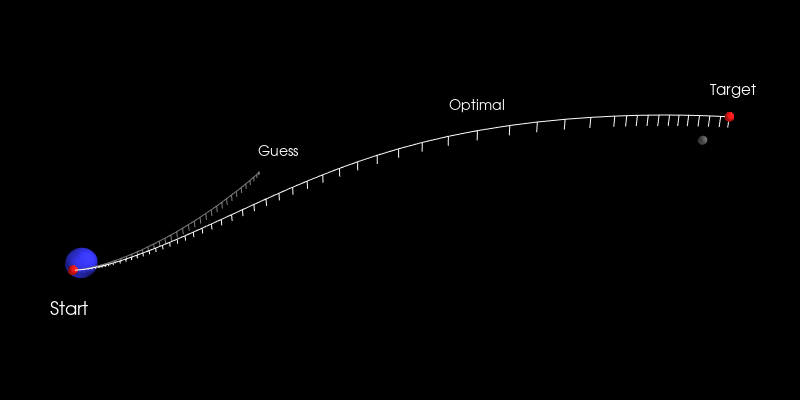

In [7]:
mlab.figure(size=(800, 400), bgcolor=(0,0,0))

mlabtools.lock_upaxis()

# Earth and Moon
mlab.points3d(-C.mu, 0, 0, scale_factor=2*6378 / C.l_star, resolution=16, color=(0.2,0.2,0.9))
mlab.points3d(1-C.mu, 0, 0, scale_factor=2*3000 / C.l_star, resolution=16, color=(0.4,0.4,0.4))

# Start and end points
c = mlabtools.surface(*np.vstack([r_target, S_init[:3]]).T,
                      color=(1, 0.1, 0.1), representation='points')
c.actor.property.trait_set(render_points_as_spheres=True, point_size=10)

# Plot each trajectory
for y, color in zip((sol_opt.y[:3], sol_guess.y[:3]),
                    (3 * (1,), 3 * (0.5,))):
    mlabtools.curves(y, color=color, line_width=1)

    # Plot height lines
    yh = np.zeros((y.shape[1], 3, 2))
    yh[:, :, 1] = y.T
    yh[:, :2, 0] = y.T[:, :2]
    mlabtools.curves(yh, color=color, line_width=1)

text = [
    (sol_guess.y[:3, -1] + (0, 0, 0.02), "Guess"),
    (sol_opt.y[:3, int(0.7 * sol_opt.y.shape[1])] + (0, 0, 0.04), "Optimal"),
    (S_init[:3] + (-0.03, 0, -0.05), "Start"),
    (r_target + (-0.06, 0, 0.04), "Target")
]
for pos, s in text:
    mlab.text(*pos[:2], s, z=pos[2], width=0.01 * len(s))

mlab.view(focalpoint=(0.4 - C.mu, 0, 0), distance=1,
          azimuth=-120, elevation=70)

mlab.gcf()